## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [22]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [23]:
train, test = keras.datasets.cifar10.load_data()

In [24]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [25]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [26]:
#def build_mlp():
"""
Build your own model
"""
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [27]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 1024
MOMENTUM = 0.95

## 作業一、試比較 save_best_only 與否的差異

In [13]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

In [15]:
"""
Write your training loop and show the results
"""
results_D86_hw1={}
for ckpt_best_only in ['yes','no']:
    model=build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer=keras.optimizers.SGD(lr=LEARNING_RATE,nesterov=True, momentum=MOMENTUM)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    if ckpt_best_only=='yes':
        model_ckpt=ModelCheckpoint(filepath='D86HW1.h5',
                                   monitor='val_loss',
                                   save_best_only=True)
        model.fit(x_train,y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test,y_test),
                  shuffle=True,
                  callbacks=[model_ckpt])
        
    elif ckpt_best_only=='no':
        model_ckpt=ModelCheckpoint(filepath='D86HW1.h5',
                                   monitor='val_loss',
                                   save_best_only=False)
        model.fit(x_train,y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test,y_test),
                  shuffle=True,
                  callbacks=[model_ckpt])
       
    # collect results
    train_loss=model.history.history['loss']
    valid_loss=model.history.history['val_loss']
    train_acc=model.history.history['acc']
    valid_acc=model.history.history['val_acc']
    
    #loadback model
    model_back = keras.models.load_model("D86HW1.h5")
    loadback_loss, loadback_acc = model_back.evaluate(x_test, y_test)
    
    # construct dictionary
    exp_name_tag = f"save_best_only is {str(ckpt_best_only)}"
        
    results_D86_hw1[exp_name_tag]={'train_loss':train_loss,
                                   'valid_loss':valid_loss,
                                   'train_acc':train_acc,
                                   'valid_acc':valid_acc,
                                   'loadback_loss':loadback_loss,
                                   'loadback_acc':loadback_acc
                                  }


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
__________

Epoch 17/20
50000/50000 [==============================] - 6s 126us/step - loss: 1.1358 - acc: 0.6085 - val_loss: 1.4574 - val_acc: 0.4859
Epoch 18/20
50000/50000 [==============================] - 6s 126us/step - loss: 1.1124 - acc: 0.6182 - val_loss: 1.4533 - val_acc: 0.4922
Epoch 19/20
50000/50000 [==============================] - 6s 127us/step - loss: 1.0901 - acc: 0.6257 - val_loss: 1.4595 - val_acc: 0.4874
Epoch 20/20
10000/10000 [==============================] - 1s 101us/step


In [16]:
# 畫圖第三種範例
# write function to plot results
def plot_results(results):
    color_bar=['dodgerblue','greenyellow','red','sienna','lime','green','aqua','maroon','mediumblue','slateblue','darkorchid','purple']
    """
    Draw the results
    """
    plt.figure(figsize=(12,9))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', label='train-'+cond, color=color_bar[i%12])
        plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'],'--', label='valid-'+cond, color=color_bar[i%12])
        plt.hlines(y=loadback_loss, xmin=0, xmax=len(train_loss), colors='r', linestyles='--', label='loadback-'+cond)
    plt.title('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show

    plt.figure(figsize=(12,9))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', label='train-'+cond, color=color_bar[i%12])
        plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'],'--', label='valid-'+cond, color=color_bar[i%12])
        plt.hlines(y=loadback_acc, xmin=0, xmax=len(train_acc), colors='r', linestyles='--', label='loadback-'+cond)
    plt.title('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

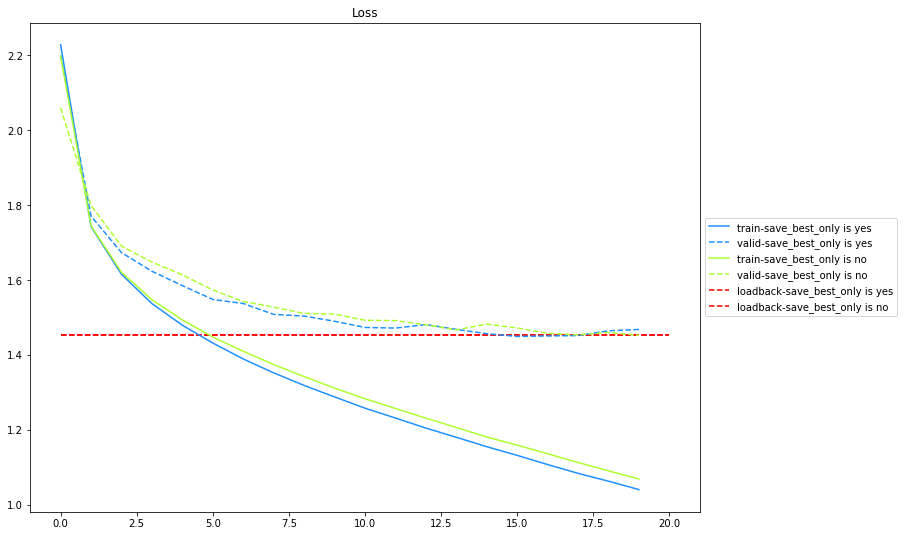

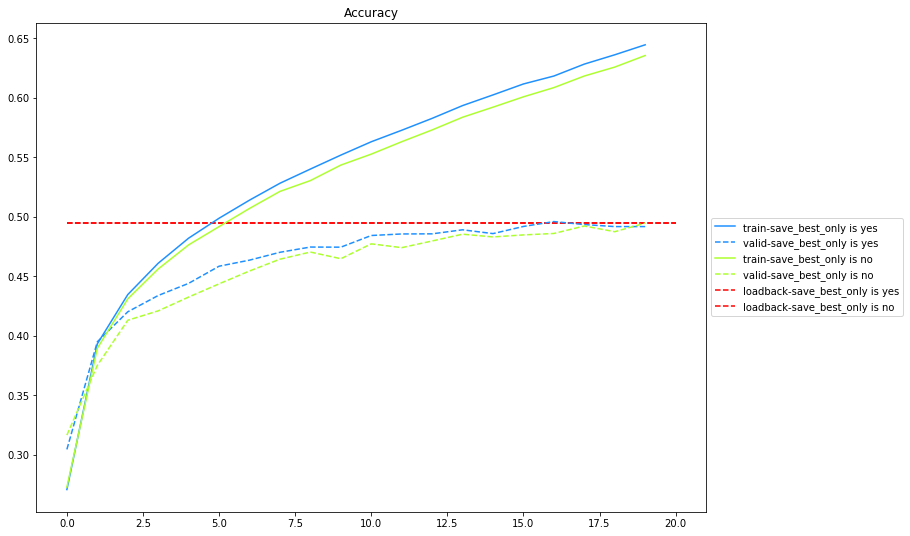

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_results(results_D86_hw1)

## 作業二、請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [30]:
results_D86_hw2={}

model=build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer=keras.optimizers.SGD(lr=LEARNING_RATE,nesterov=True, momentum=MOMENTUM)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model_ckpt=ModelCheckpoint(filepath='D86HW2.h5',
                           monitor='val_loss',
                           save_best_only=False,
                           save_weights_only=True)
model.fit(x_train,y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test,y_test),
          shuffle=True,
          callbacks=[model_ckpt])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512       
__________

In [32]:
keras.backend.clear_session()
#create new model
model_back2 = build_mlp(input_shape=x_train.shape[1:])

#load back weights of model
model_back2.summary()
model_back2.load_weights("D86HW2.h5")

model_back2.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

#evaluate model_back2
loss_loadback, acc_loadback = model_back2.evaluate(x_test, y_test)
print(f'Loss: {loss_loadback}, Acccuracy: {acc_loadback}')

#predict x_test
y_predict_model_back2=model_back2.predict(x_test)
for i in range(len(x_test)):
    print(f"X= {x_test[i]} , Predicted = {y_predict_model_back2[i]}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

 0.08587977 0.01655876 0.01278791 0.04914206]
X= [0.5254902  0.47843137 0.43137255 ... 0.50588235 0.49411765 0.44313725] , Predicted = [0.05108259 0.08030741 0.00635505 0.02623555 0.02228488 0.02634692
 0.00517517 0.06031544 0.02354784 0.6983491 ]
X= [0.94117647 0.93333333 0.9372549  ... 0.16470588 0.16078431 0.17254902] , Predicted = [0.04406968 0.1663921  0.00650693 0.00593446 0.00182545 0.00870857
 0.00666798 0.02587636 0.41508552 0.31893283]
X= [0.34117647 0.40392157 0.36470588 ... 0.25882353 0.33333333 0.32156863] , Predicted = [0.00260925 0.00113572 0.62638885 0.20824851 0.01030972 0.09590128
 0.00595274 0.01325584 0.02989423 0.00630393]
X= [0.72156863 0.82745098 0.70588235 ... 0.51372549 0.27843137 0.13333333] , Predicted = [0.01400351 0.00540869 0.44122162 0.01657663 0.0961132  0.06981398
 0.05945124 0.27208453 0.00103168 0.02429484]
X= [0.59607843 0.57647059 0.58039216 ... 0.49019608 0.45882353 0.47058824] , Predicted = [0.09372794 0.00465178 0.17318381 0.05823199 0.20795444 0

 2.9213564e-03 3.4345867e-04 1.9994827e-03 3.1875154e-01 3.0017856e-03]
X= [0.34117647 0.60784314 0.84705882 ... 0.64705882 0.6745098  0.64313725] , Predicted = [0.04907999 0.01911031 0.00128429 0.0007367  0.00277545 0.00385402
 0.00151292 0.02525956 0.44995505 0.44643176]
X= [0.97647059 0.99215686 0.98823529 ... 0.73333333 0.71764706 0.62352941] , Predicted = [2.1335959e-02 5.8903778e-01 1.9325227e-02 4.3795176e-04 4.3286062e-03
 4.6538636e-03 8.5391849e-03 6.1780509e-02 3.4728576e-03 2.8708792e-01]
X= [0. 0. 0. ... 0. 0. 0.] , Predicted = [3.9002672e-02 3.6927091e-03 4.0533986e-02 1.5652647e-02 3.7974928e-02
 9.2716061e-02 4.3500520e-04 2.2648595e-02 7.3471713e-01 1.2626230e-02]
X= [0.30196078 0.23529412 0.12156863 ... 0.44705882 0.45098039 0.31764706] , Predicted = [3.2552597e-03 1.1602393e-03 1.1999789e-01 2.6474933e-03 7.0275974e-01
 1.0615019e-02 5.5958256e-02 1.0208031e-01 3.7942454e-04 1.1464275e-03]
X= [0.27058824 0.24705882 0.28627451 ... 0.4745098  0.49803922 0.45882353] , P

 1.1448213e-03 7.1394729e-04 1.3877264e-02 1.7855059e-02 6.6627640e-01]
X= [0.47843137 0.6627451  0.78039216 ... 0.39607843 0.39607843 0.37254902] , Predicted = [0.04691853 0.01362538 0.05357001 0.00635112 0.00350652 0.00176287
 0.00382925 0.00205157 0.73160094 0.1367839 ]
X= [0.90588235 0.83529412 0.83137255 ... 0.63529412 0.50980392 0.54117647] , Predicted = [0.10537554 0.24289766 0.01013712 0.06018538 0.0473706  0.02690754
 0.0598932  0.08433493 0.29853827 0.06435982]
X= [0.42745098 0.48627451 0.31764706 ... 0.4        0.43137255 0.29803922] , Predicted = [4.7048177e-03 2.4522949e-04 2.3985481e-01 1.5223104e-02 6.6969174e-01
 7.8170225e-03 5.8356579e-02 1.6686884e-03 2.1986666e-03 2.3918830e-04]
X= [0.62745098 0.54901961 0.5372549  ... 0.64705882 0.55686275 0.54901961] , Predicted = [0.00315693 0.00275496 0.0386662  0.16616979 0.25186524 0.13726085
 0.25250894 0.13004851 0.00803443 0.00953417]
X= [0.00392157 0.00392157 0.00392157 ... 0.46666667 0.34901961 0.34117647] , Predicted = [

 0.5248859  0.05235019 0.00969534 0.02940479]
X= [0.20392157 0.1254902  0.12941176 ... 0.25098039 0.16078431 0.12941176] , Predicted = [0.00314846 0.04885204 0.07616157 0.04230249 0.40470168 0.12128673
 0.11825512 0.17465596 0.00638728 0.00424863]
X= [0.35294118 0.39215686 0.33333333 ... 0.28627451 0.3254902  0.28235294] , Predicted = [1.8374834e-02 1.3472198e-04 1.7967038e-02 3.2237169e-01 1.3229586e-02
 4.6756506e-01 2.7713899e-02 8.1084862e-02 4.5109134e-02 6.4490875e-03]
X= [0.41176471 0.63921569 0.72941176 ... 0.99215686 0.99215686 0.99215686] , Predicted = [0.09575189 0.14747593 0.06478695 0.01555166 0.204611   0.03886676
 0.017023   0.2279058  0.05377123 0.13425575]
X= [0.14117647 0.34117647 0.87058824 ... 0.83529412 0.81568627 0.82352941] , Predicted = [1.1433110e-02 2.4461482e-01 1.7251012e-05 5.7372812e-04 2.3492957e-03
 1.0380818e-03 4.3836422e-05 2.4492005e-03 2.5657082e-03 7.3491502e-01]
X= [0.89019608 0.82352941 0.79607843 ... 0.87843137 0.79215686 0.76862745] , Predicted

 0.0012368  0.00563396 0.36287048 0.00699267]
X= [0.49019608 0.5254902  0.53333333 ... 0.54901961 0.58823529 0.56470588] , Predicted = [3.2610070e-02 3.1499914e-04 6.1689401e-01 3.3895720e-02 1.3119081e-01
 1.1150979e-01 1.0145664e-02 3.4254547e-02 2.6393969e-02 2.7903717e-03]
X= [0.14509804 0.23529412 0.30588235 ... 0.10980392 0.16078431 0.18431373] , Predicted = [0.04002809 0.01832532 0.00663291 0.12510948 0.00494078 0.2906937
 0.02669034 0.0338133  0.1802787  0.27348742]
X= [1.         1.         0.99607843 ... 0.98431373 0.98823529 0.97647059] , Predicted = [0.00306333 0.00144545 0.00404667 0.04627107 0.06625462 0.10028772
 0.1437399  0.5318383  0.00131763 0.10173536]
X= [0.43921569 0.4745098  0.36078431 ... 0.76470588 0.74509804 0.71372549] , Predicted = [6.4391084e-03 9.0721375e-01 1.5528391e-04 4.4401866e-04 4.9708528e-03
 4.2396790e-04 2.6221285e-03 2.5717798e-03 3.3858404e-02 4.1300677e-02]
X= [0.09803922 0.25490196 0.49803922 ... 0.63921569 0.66666667 0.78039216] , Predicted 

 0.0410201  0.29514652 0.08727153 0.01602018]
X= [0.09411765 0.09019608 0.07843137 ... 0.18431373 0.18823529 0.16862745] , Predicted = [7.0180795e-03 1.7178938e-02 7.7635399e-03 5.0638694e-02 5.9647139e-02
 1.3204105e-02 8.3554089e-01 4.3451189e-04 4.0024552e-03 4.5716385e-03]
X= [0.44313725 0.4745098  0.41568627 ... 0.6        0.58039216 0.50196078] , Predicted = [0.02733808 0.00197928 0.24807128 0.03369078 0.50769    0.07071548
 0.01863497 0.04363839 0.04603197 0.00220981]
X= [0.38823529 0.51372549 0.56470588 ... 0.40784314 0.52156863 0.57647059] , Predicted = [0.42364067 0.00580039 0.20386639 0.03043498 0.09174863 0.02035774
 0.0301689  0.00902776 0.18108338 0.0038712 ]
X= [0.22352941 0.29803922 0.19607843 ... 0.21176471 0.2745098  0.20392157] , Predicted = [0.02292318 0.01833898 0.87223333 0.01604004 0.02596299 0.00985873
 0.01392506 0.01079772 0.00684425 0.00307574]
X= [0.05098039 0.02352941 0.04313725 ... 0.85098039 0.77647059 0.76862745] , Predicted = [0.00093327 0.00065374 0.00

 0.00629227 0.0127299  0.79287636 0.01566199]
X= [0.12941176 0.13333333 0.10980392 ... 0.44705882 0.44705882 0.45490196] , Predicted = [6.5770829e-03 6.9965719e-04 2.4552436e-01 6.7158419e-01 1.9327393e-02
 2.6086723e-02 2.4920637e-02 3.9425087e-03 9.4345200e-04 3.9402739e-04]
X= [0.56470588 0.4745098  0.47843137 ... 0.82745098 0.82745098 0.82352941] , Predicted = [0.02146993 0.05438441 0.01234794 0.11301199 0.05640212 0.02164212
 0.01220286 0.6530876  0.01537177 0.04007932]
X= [0.04705882 0.09411765 0.1254902  ... 0.30588235 0.31372549 0.22352941] , Predicted = [0.01180843 0.00773767 0.09578476 0.05145575 0.4125542  0.288622
 0.05699938 0.01360269 0.05813138 0.00330376]
X= [0.42745098 0.34117647 0.22745098 ... 0.36470588 0.36470588 0.19607843] , Predicted = [0.00366283 0.00048636 0.44815585 0.03968229 0.34338844 0.07441483
 0.04129665 0.04767187 0.00074236 0.0004983 ]
X= [0.06666667 0.05490196 0.03921569 ... 0.90588235 0.93333333 0.94509804] , Predicted = [0.09343693 0.03568896 0.0580

 0.00430309 0.18757562 0.00145989 0.02099604]
X= [0.25098039 0.11764706 0.38431373 ... 0.46666667 0.41960784 0.35686275] , Predicted = [0.10575815 0.02109362 0.02262973 0.4972224  0.05702439 0.10701303
 0.08447419 0.06928383 0.01044122 0.02505952]
X= [0.03137255 0.05490196 0.02352941 ... 0.29019608 0.23529412 0.20784314] , Predicted = [0.00373715 0.01252168 0.0219465  0.26615793 0.00493901 0.15190749
 0.51847833 0.00353912 0.0136223  0.00315056]
X= [0.36470588 0.31764706 0.25098039 ... 0.3254902  0.29019608 0.30196078] , Predicted = [4.6687531e-03 9.9122775e-01 1.6178237e-04 7.1157330e-05 1.5417188e-05
 2.8787750e-05 5.0673152e-06 2.1491107e-05 2.2011921e-03 1.5986195e-03]
X= [0.44705882 0.42745098 0.35294118 ... 0.76470588 0.76862745 0.71764706] , Predicted = [0.00086252 0.00427763 0.00916557 0.08329745 0.00772857 0.14417922
 0.03965728 0.69806087 0.00743575 0.00533519]
X= [0.18431373 0.11372549 0.09019608 ... 0.36862745 0.35294118 0.2745098 ] , Predicted = [0.02713919 0.01639926 0.09

 3.6703884e-03 1.8089334e-04 3.3192276e-03 5.7417685e-03 7.1351373e-01]
X= [0.40392157 0.58039216 0.69411765 ... 0.20392157 0.19215686 0.23137255] , Predicted = [0.3559243  0.0043317  0.07607635 0.00234578 0.01151451 0.00173621
 0.00335632 0.00357085 0.5282886  0.01285526]
X= [0.03137255 0.03137255 0.03529412 ... 0.04705882 0.16078431 0.17647059] , Predicted = [7.1158192e-06 7.0879323e-05 1.7314775e-04 3.7238994e-01 2.9175999e-04
 6.1932403e-01 3.2630712e-03 1.5910888e-03 2.8480047e-03 4.0916937e-05]
X= [0.70588235 0.74901961 0.79607843 ... 0.51372549 0.45098039 0.41568627] , Predicted = [0.06114989 0.01979569 0.12054222 0.17806026 0.03724548 0.31671733
 0.01829722 0.16370638 0.00333343 0.08115209]
X= [0.57254902 0.5372549  0.5372549  ... 0.46666667 0.34117647 0.21960784] , Predicted = [0.03447559 0.00786851 0.18214093 0.03529236 0.19876938 0.06842504
 0.02551278 0.42600667 0.00147198 0.02003666]
X= [1.         1.         1.         ... 0.73333333 0.76078431 0.7254902 ] , Predicted = [

 0.05042582 0.00226507 0.24427591 0.12218868]
X= [0.72941176 0.69411765 0.68235294 ... 0.12156863 0.2        0.25098039] , Predicted = [0.00544403 0.00715198 0.02452121 0.66305214 0.00366367 0.18678828
 0.00711574 0.09804977 0.0015763  0.00263682]
X= [0.78039216 0.58823529 0.36470588 ... 0.78823529 0.65098039 0.37647059] , Predicted = [1.6038305e-04 9.0182275e-01 6.4571614e-05 7.9304900e-06 1.2208609e-03
 1.4471958e-04 5.9371110e-04 1.9786842e-03 6.7626926e-05 9.3938753e-02]
X= [1. 1. 1. ... 1. 1. 1.] , Predicted = [0.17738055 0.01017732 0.26516926 0.05066272 0.06254649 0.02942663
 0.3508181  0.0042115  0.03066291 0.01894445]
X= [0.18039216 0.45490196 0.74117647 ... 0.2        0.34117647 0.36470588] , Predicted = [6.02780044e-01 1.03276195e-02 6.33699819e-03 4.80780494e-04
 1.35439902e-03 2.78347696e-04 5.00642345e-04 1.03865971e-03
 3.24302405e-01 5.25999926e-02]
X= [0.30588235 0.36470588 0.15686275 ... 0.60784314 0.78431373 0.44705882] , Predicted = [0.021817   0.01911011 0.24399896 

 2.5533577e-03 1.6233642e-04 3.4926215e-04 2.3875181e-01 6.8300635e-02]
X= [0.69803922 0.44705882 0.28627451 ... 0.71764706 0.54509804 0.41176471] , Predicted = [0.05481441 0.01291759 0.14026599 0.2011894  0.22728169 0.09755168
 0.04203292 0.09882817 0.06151258 0.06360553]
X= [0.77647059 0.49411765 0.51764706 ... 0.6627451  0.4        0.36470588] , Predicted = [0.0058772  0.00136566 0.14717597 0.29993486 0.16703469 0.06604618
 0.28212613 0.02290644 0.00286791 0.00466486]
X= [0.21960784 0.36078431 0.19215686 ... 0.45098039 0.4        0.3372549 ] , Predicted = [0.01432209 0.02135183 0.31901136 0.04303597 0.09165023 0.14955619
 0.31654283 0.02132956 0.01765468 0.00554525]
X= [0.38823529 0.39215686 0.25490196 ... 0.44705882 0.43137255 0.3372549 ] , Predicted = [0.00680051 0.00208265 0.21079351 0.08238507 0.4293076  0.17816481
 0.0738057  0.00794225 0.00581437 0.00290361]
X= [0.48627451 0.50196078 0.41176471 ... 0.9372549  0.82745098 0.86666667] , Predicted = [0.02765155 0.02477193 0.007520

 0.01766842 0.02733609 0.21459302 0.2876078 ]
X= [0.77647059 0.69803922 0.54117647 ... 0.83137255 0.70980392 0.55686275] , Predicted = [0.00717157 0.02062606 0.30091253 0.13903761 0.19655299 0.17086591
 0.07827673 0.07999272 0.00133084 0.00523312]
X= [0.2627451  0.21960784 0.27843137 ... 0.91764706 0.87058824 0.82745098] , Predicted = [0.00190787 0.00123645 0.07599536 0.06579165 0.00618073 0.39231628
 0.01688762 0.42529237 0.00842609 0.00596552]
X= [0.43137255 0.4745098  0.39607843 ... 0.47843137 0.45882353 0.44313725] , Predicted = [0.0472154  0.01260229 0.6518141  0.03556119 0.08403017 0.03123181
 0.05934067 0.0278598  0.04159352 0.00875118]
X= [0.57254902 0.50980392 0.57254902 ... 0.63137255 0.61568627 0.62745098] , Predicted = [0.09557968 0.00396464 0.2566109  0.0458317  0.11659526 0.25219908
 0.00070603 0.17175059 0.00596759 0.05079445]
X= [0.94117647 0.96862745 0.96862745 ... 0.75686275 0.74509804 0.70588235] , Predicted = [4.7727179e-02 1.7195407e-01 2.2897490e-03 1.1277205e-02 

 0.5638678  0.10921053 0.00871109 0.0022514 ]
X= [0.92941176 0.98431373 0.99607843 ... 0.08235294 0.14509804 0.2       ] , Predicted = [1.96080670e-01 8.37270077e-03 5.25658624e-03 5.03118383e-04
 3.46796424e-03 1.01288184e-04 3.32657015e-04 2.06925161e-03
 7.75697529e-01 8.11827369e-03]
X= [0.5254902  0.56078431 0.58823529 ... 0.18823529 0.14901961 0.10196078] , Predicted = [0.30167753 0.0188204  0.01287709 0.12823784 0.01785583 0.02644647
 0.00159964 0.40038222 0.07434772 0.01775531]
X= [0.43529412 0.65098039 0.69803922 ... 0.29411765 0.44313725 0.49803922] , Predicted = [0.16037099 0.20900857 0.00858594 0.02156757 0.02292472 0.01170603
 0.01569828 0.02984115 0.28268456 0.23761225]
X= [0.42745098 0.48627451 0.38431373 ... 0.36862745 0.24705882 0.05098039] , Predicted = [0.01858304 0.00898145 0.05595734 0.00744051 0.3041656  0.02273129
 0.02125428 0.55853564 0.0008532  0.00149771]
X= [0.13333333 0.12941176 0.06666667 ... 0.76862745 0.69803922 0.56078431] , Predicted = [1.4592301e-04 2

 2.15908187e-03 5.96500759e-04]
X= [0.41960784 0.36078431 0.2745098  ... 0.52941176 0.23137255 0.24313725] , Predicted = [0.01380531 0.01077558 0.25481674 0.15743169 0.08424549 0.02842662
 0.02698547 0.41714615 0.0010802  0.00528667]
X= [0.19215686 0.14117647 0.10980392 ... 0.38431373 0.38431373 0.26666667] , Predicted = [0.00270424 0.0140026  0.00840914 0.02887478 0.00079332 0.27248853
 0.07408864 0.590147   0.00275542 0.0057363 ]
X= [0.40392157 0.44313725 0.49019608 ... 0.41960784 0.39215686 0.41176471] , Predicted = [0.05818004 0.00564783 0.08199814 0.27320477 0.08928887 0.19174834
 0.02126882 0.14496142 0.07903281 0.05466905]
X= [0.31764706 0.34117647 0.23921569 ... 0.50980392 0.45882353 0.39607843] , Predicted = [0.00959922 0.02311963 0.04556063 0.0464063  0.26965302 0.08564113
 0.26981387 0.1572547  0.00478945 0.08816204]
X= [0.03529412 0.0745098  0.01568627 ... 0.33333333 0.40392157 0.2       ] , Predicted = [0.01604435 0.00090953 0.17388122 0.00455234 0.5900604  0.0317448
 0.08

 9.7905780e-05 2.8629883e-04 2.9134343e-03 3.8376236e-03 9.4536579e-01]
X= [0.78039216 0.76078431 0.74901961 ... 0.69803922 0.67843137 0.65490196] , Predicted = [0.05432741 0.00084783 0.1205068  0.18040411 0.31916016 0.18421446
 0.02579697 0.059224   0.05196301 0.00355523]
X= [0.5372549  0.29411765 0.2627451  ... 0.92156863 0.77647059 0.80392157] , Predicted = [0.01058247 0.03490846 0.13022041 0.4295493  0.06982417 0.18309942
 0.03200586 0.08474338 0.02182476 0.0032419 ]
X= [1.         1.         1.         ... 0.39607843 0.36078431 0.23921569] , Predicted = [0.03532445 0.00328396 0.2761018  0.3470653  0.05023927 0.03351922
 0.1336657  0.01812189 0.09286828 0.00981004]
X= [0.42745098 0.37254902 0.3254902  ... 0.50588235 0.43137255 0.38823529] , Predicted = [0.05369752 0.10484809 0.38829654 0.00997755 0.06864138 0.17130516
 0.04330943 0.12471014 0.01906549 0.0161486 ]
X= [0.56078431 0.69803922 0.81176471 ... 0.29803922 0.41960784 0.53333333] , Predicted = [1.1282558e-01 1.4915369e-03 8.

 3.9660805e-01 1.3712692e-01 2.8932157e-03 4.4061318e-03 6.4115779e-04]
X= [0.61568627 0.70980392 0.85098039 ... 0.89411765 0.76470588 0.68235294] , Predicted = [1.1820569e-02 2.0551722e-01 4.1123299e-04 6.3083181e-03 9.9758839e-04
 5.1502194e-03 2.6694126e-03 1.8798150e-03 5.3594327e-01 2.2930236e-01]
X= [0.53333333 0.4745098  0.47843137 ... 0.33333333 0.27843137 0.23137255] , Predicted = [0.17204276 0.29538253 0.03624237 0.03307645 0.00926651 0.05574605
 0.02372332 0.03824019 0.03221459 0.30406523]
X= [0.2627451  0.30980392 0.37254902 ... 0.17254902 0.17254902 0.21568627] , Predicted = [0.02192474 0.00198972 0.00948217 0.09048221 0.0632573  0.04014856
 0.7276835  0.00505545 0.01988053 0.02009593]
X= [0.45882353 0.51372549 0.64313725 ... 0.99607843 0.99607843 0.99607843] , Predicted = [0.6336939  0.0368114  0.01161027 0.05327974 0.00895865 0.01098348
 0.00066499 0.01842312 0.05167163 0.17390299]
X= [0.49803922 0.41176471 0.49803922 ... 0.36862745 0.34117647 0.32941176] , Predicted = [

 0.17504051 0.00854917 0.23331875 0.22305861]
X= [0.58431373 0.69019608 0.50196078 ... 0.27843137 0.25882353 0.20392157] , Predicted = [0.0048642  0.00168643 0.3278625  0.08241715 0.16766581 0.01391812
 0.3789632  0.01741952 0.00442413 0.00077902]
X= [0.63921569 0.57647059 0.43529412 ... 0.46666667 0.46666667 0.55686275] , Predicted = [0.02730873 0.17911984 0.00579279 0.02558783 0.00865385 0.06936935
 0.10916549 0.01812536 0.51318187 0.04369494]
X= [0.35686275 0.42352941 0.41176471 ... 0.98039216 0.83137255 0.70980392] , Predicted = [0.00367889 0.00153325 0.12167978 0.01503382 0.15832563 0.06391418
 0.00103829 0.6320204  0.00196355 0.00081209]
X= [0.25098039 0.30588235 0.34509804 ... 0.16470588 0.17647059 0.15294118] , Predicted = [0.01287    0.01328835 0.2581051  0.02992456 0.13764384 0.0701623
 0.1775799  0.09882528 0.08368915 0.11791139]
X= [0.17254902 0.34901961 0.36078431 ... 0.5254902  0.48627451 0.39215686] , Predicted = [0.24006572 0.05640691 0.1666463  0.0061271  0.18734114 0.

 1.3991971e-02 2.4289959e-03 9.1600227e-01 2.5134833e-04 2.4111411e-02]
X= [0.45490196 0.37647059 0.23137255 ... 0.5372549  0.48627451 0.32941176] , Predicted = [0.00790741 0.00213513 0.5330219  0.01691376 0.21388541 0.06718267
 0.07580396 0.08093719 0.00143365 0.00077887]
X= [0.98823529 1.         0.98039216 ... 0.37647059 0.39607843 0.21176471] , Predicted = [0.00995329 0.00955222 0.11178183 0.09704271 0.16846685 0.14477633
 0.18730427 0.21565947 0.01344131 0.04202184]
X= [0.09803922 0.12941176 0.10196078 ... 0.47058824 0.48627451 0.41568627] , Predicted = [2.0685261e-04 3.0536780e-01 3.3170450e-04 1.4757123e-03 2.2572905e-04
 1.9964301e-03 5.2241511e-03 3.9089285e-03 1.1542816e-02 6.6971982e-01]
X= [0.91372549 0.93333333 0.90980392 ... 0.95686275 0.97647059 0.96078431] , Predicted = [0.00087509 0.02200113 0.00856493 0.05566922 0.01809467 0.08313169
 0.42171788 0.00361566 0.0142556  0.37207416]
X= [0.32156863 0.43529412 0.48627451 ... 0.27058824 0.23921569 0.18431373] , Predicted = [

 0.13565503 0.03745151 0.04122901 0.15170477]
X= [0.35294118 0.56470588 0.67843137 ... 0.20392157 0.2627451  0.25882353] , Predicted = [0.10491173 0.03037584 0.01962517 0.01358609 0.06642722 0.00313774
 0.00299451 0.00524398 0.65815413 0.09554369]
X= [0.42352941 0.34509804 0.34901961 ... 0.91372549 0.89411765 0.90196078] , Predicted = [0.03414866 0.18004288 0.01159815 0.18667161 0.09029068 0.04770669
 0.03983378 0.08081568 0.02836088 0.30053103]
X= [0.35686275 0.38431373 0.22352941 ... 0.2745098  0.31764706 0.20784314] , Predicted = [0.01010467 0.00126536 0.4246582  0.04130193 0.2524543  0.02348232
 0.23861803 0.00346563 0.0041376  0.0005119 ]
X= [0.         0.         0.         ... 0.00784314 0.00784314 0.00784314] , Predicted = [1.5029587e-03 2.1968181e-04 4.1703334e-01 3.3259374e-01 8.1624454e-03
 1.6367316e-01 1.3050322e-02 4.4411473e-02 1.8619427e-02 7.3346013e-04]
X= [0.44313725 0.31372549 0.2        ... 0.02352941 0.02745098 0.03137255] , Predicted = [0.09932777 0.02270348 0.07

 2.7656026e-02 3.1131074e-02 1.4110030e-02 1.8543946e-03 4.7472568e-04]
X= [0.54901961 0.61176471 0.74117647 ... 0.54117647 0.52941176 0.52156863] , Predicted = [0.0428813  0.00088288 0.05275781 0.16006303 0.01626954 0.02922912
 0.04922142 0.4476236  0.19201638 0.00905494]
X= [0.36078431 0.36862745 0.2745098  ... 0.38431373 0.38431373 0.29019608] , Predicted = [0.01484327 0.00173602 0.2702553  0.01872929 0.34280694 0.01572556
 0.32584596 0.00390727 0.0049002  0.00125006]
X= [0.8627451  0.75686275 0.47058824 ... 0.76470588 0.54509804 0.41176471] , Predicted = [0.02426789 0.00122623 0.02282994 0.09263517 0.04359395 0.02571646
 0.70443845 0.01145113 0.00420156 0.06963925]
X= [0.12941176 0.05882353 0.04313725 ... 1.         1.         1.        ] , Predicted = [0.00320216 0.03032121 0.0905857  0.21311493 0.12701406 0.05487398
 0.39328095 0.07744455 0.00140414 0.00875827]
X= [0.12156863 0.13333333 0.10196078 ... 0.2        0.28235294 0.18823529] , Predicted = [1.8166122e-04 5.4289135e-03 7.

 0.03209431 0.0087812  0.09083983 0.00176364]
X= [0.64705882 0.76470588 0.89019608 ... 0.19607843 0.20392157 0.22352941] , Predicted = [7.3353924e-02 3.7923384e-02 3.6533414e-03 9.0762111e-04 1.0437688e-02
 4.0790753e-04 1.4617220e-03 4.2538373e-03 6.5080112e-01 2.1679942e-01]
X= [0.2745098  0.23529412 0.05098039 ... 0.2745098  0.29019608 0.01568627] , Predicted = [0.01550463 0.01418341 0.07713266 0.03073675 0.09883983 0.00479768
 0.74190223 0.01093169 0.00301859 0.00295252]
X= [0.21568627 0.2        0.2        ... 0.71764706 0.58823529 0.44313725] , Predicted = [1.1698021e-02 1.6471180e-04 5.4255910e-02 3.0548448e-02 8.4965354e-01
 2.7468352e-02 6.4808927e-03 1.8568467e-02 4.3127753e-04 7.3042279e-04]
X= [0.65098039 0.6745098  0.6745098  ... 0.75686275 0.76470588 0.74901961] , Predicted = [0.07315937 0.00672694 0.28112894 0.15428264 0.10414878 0.06024053
 0.09073349 0.01816371 0.18367296 0.02774259]
X= [0.43529412 0.43137255 0.42745098 ... 0.43529412 0.39607843 0.35294118] , Predicted

X= [0.91372549 0.90980392 0.89019608 ... 0.91764706 0.90980392 0.86666667] , Predicted = [3.2249067e-04 4.9467743e-03 3.1950823e-03 3.0190442e-02 3.2466915e-03
 4.3052338e-02 2.0410486e-02 8.9061433e-01 8.7946632e-05 3.9334381e-03]
X= [0.56862745 0.56470588 0.55686275 ... 0.53333333 0.42745098 0.4       ] , Predicted = [0.06607338 0.04503565 0.08417027 0.4486693  0.09530836 0.03484883
 0.07719048 0.12212402 0.00506288 0.02151682]
X= [0.40784314 0.4        0.41568627 ... 0.4745098  0.4627451  0.4745098 ] , Predicted = [1.6315548e-04 3.2315662e-04 1.0362936e-02 5.3624707e-01 1.2105402e-03
 3.6069196e-01 6.5058358e-02 2.3720641e-02 6.5718271e-04 1.5650927e-03]
X= [0.5372549  0.58823529 0.6745098  ... 0.4        0.38823529 0.27058824] , Predicted = [0.00266652 0.00520679 0.13754815 0.36575943 0.01659367 0.39768454
 0.00353137 0.00517692 0.06484903 0.00098342]
X= [0.65098039 0.60392157 0.44313725 ... 0.79607843 0.78039216 0.69411765] , Predicted = [2.6065675e-03 9.5437060e-04 8.3394295e-01 

 0.01213467 0.12695967 0.00797495 0.4604456 ]
X= [0.29411765 0.44705882 0.25882353 ... 0.25098039 0.40392157 0.25490196] , Predicted = [0.10565177 0.12001373 0.07820062 0.02541438 0.00791822 0.21212964
 0.06239621 0.3222657  0.05213305 0.01387673]
X= [0.49411765 0.49019608 0.41176471 ... 0.83921569 0.67843137 0.65490196] , Predicted = [0.00451514 0.01512384 0.05002777 0.3569158  0.02289277 0.06725719
 0.00756691 0.0466242  0.00211791 0.42695853]
X= [0.82352941 0.82352941 0.82352941 ... 0.47058824 0.47058824 0.47058824] , Predicted = [0.23078386 0.09986507 0.1003376  0.01928044 0.01521104 0.02677283
 0.01451186 0.04732129 0.2340532  0.21186273]
X= [1.         1.         0.99607843 ... 0.99215686 0.99607843 0.97647059] , Predicted = [1.2754494e-01 1.4006083e-04 7.3563293e-02 4.0032212e-02 7.2425790e-03
 5.7611966e-01 1.7960034e-02 1.0084532e-01 5.3473171e-02 3.0786567e-03]
X= [0.18039216 0.28627451 0.12156863 ... 0.37647059 0.41568627 0.30196078] , Predicted = [0.02501411 0.00088209 0.10